In [ ]:
# Setup venv and install jupyter kernel
import sys
!{sys.executable} -m venv cebra
!cebra/bin/python -m pip install --upgrade pip
!cebra/bin/python -m pip install jupyter ipykernel
!cebra/bin/python -m ipykernel install --user --name=cebra --display-name "Python (CEBRA)"

In [2]:
# Check venv has been registered as juptyer kernel
!jupyter kernelspec list

Available kernels:
  cebra      /home/jake/.local/share/jupyter/kernels/cebra
  python3    /home/jake/.local/share/jupyter/kernels/python3


In [3]:
# Restart kernel and switch to Python (CEBRA)

In [4]:
import sys
sys.executable # check that we're using the correct kernel `.../cebra/bin/python`

'/home/jake/cebra/bin/python'

In [ ]:
# !{sys.executable} -m pip install --pre 'cebra[datasets,demos]'
# !{sys.executable} -m pip install --upgrade git+https://github.com/AdaptiveMotorControlLab/cebra.git


In [ ]:
import torch
print(torch.version.cuda)
# 12.4

In [ ]:
# torch>=2.6 breaks loading cebra models, so downgrade to 2.5.0
# !{sys.executable} -m pip uninstall -y torch torchvision torchaudio
# !{sys.executable} -m pip install torch==2.5.0 torchvision==0.20.0 torchaudio==2.5.0 --index-url https://download.pytorch.org/whl/cu124

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import cebra.datasets
from cebra import CEBRA

In [2]:
import random
import copy
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error
# !mkdir data

# Ensure directories exist
os.makedirs("./cebra_models", exist_ok=True)
os.makedirs("./cebra_figures", exist_ok=True)

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(42)

hippocampus_pos = {}
hippocampus_pos["achilles"] = cebra.datasets.init('rat-hippocampus-single-achilles')
hippocampus_pos["buddy"] = cebra.datasets.init('rat-hippocampus-single-buddy')
hippocampus_pos["cicero"] = cebra.datasets.init('rat-hippocampus-single-cicero')
hippocampus_pos["gatsby"] = cebra.datasets.init('rat-hippocampus-single-gatsby')

# Apply log1p and per-neuron standardization to neural data,
# and standardize continuous_index.
for key in hippocampus_pos.keys():
    data = hippocampus_pos[key]
    
    # Take log1p of neural data
    neural_log = data.neural#torch.log1p(data.neural)
    
    # Compute mean and std for each neuron (across the time dimension)
    neuron_mean = neural_log.mean(dim=0, keepdim=True)
    neuron_std = neural_log.std(dim=0, keepdim=True)
    
    # Identify neurons with little or no variance.
    valid_mask = neuron_std > 1e-6
    if valid_mask.sum() < neuron_std.shape[1]:
        num_removed = neuron_std.shape[1] - valid_mask.sum().item()
        print(f"{num_removed} neuron(s) removed from {key} due to near-zero variance.")
    
    # Filter out neurons with near-zero variance.
    neural_log = neural_log[:, valid_mask.squeeze()]
    neuron_mean = neuron_mean[:, valid_mask.squeeze()]
    neuron_std = neuron_std[:, valid_mask.squeeze()]
    
    # Standardize each neuron individually.
    data.neural_standardized = (neural_log - neuron_mean) / neuron_std

    # Standardize continuous_index across the feature dimension.
    ci_mean = data.continuous_index.mean(dim=0, keepdim=True)
    ci_std = data.continuous_index.std(dim=0, keepdim=True)
    data.continuous_index_standardized = (data.continuous_index - ci_mean) / ci_std

    hippocampus_pos[key] = data

print(hippocampus_pos.keys())


1 neuron(s) removed from achilles due to near-zero variance.
3 neuron(s) removed from buddy due to near-zero variance.
1 neuron(s) removed from gatsby due to near-zero variance.
dict_keys(['achilles', 'buddy', 'cicero', 'gatsby'])


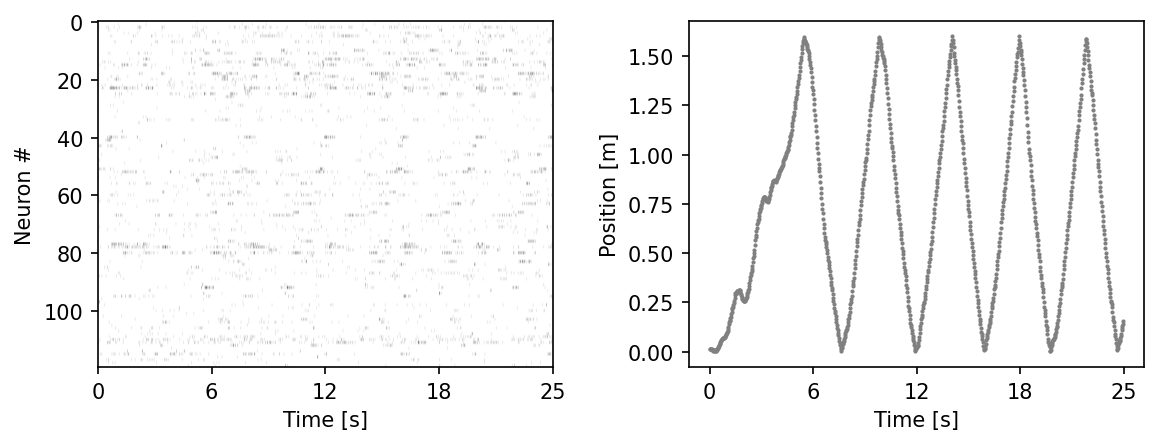

In [3]:
fig = plt.figure(figsize=(9,3), dpi=150)
plt.subplots_adjust(wspace = 0.3)
ax = plt.subplot(121)
ax.imshow(hippocampus_pos["achilles"].neural.numpy()[:1000].T, aspect = 'auto', cmap = 'gray_r')
plt.ylabel('Neuron #')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))

ax2 = plt.subplot(122)
ax2.scatter(np.arange(1000), hippocampus_pos["achilles"].continuous_index[:1000,0], c = 'gray', s=1)
plt.ylabel('Position [m]')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))
plt.savefig("./cebra_figures/original_unshuffled_data.png", bbox_inches="tight")
plt.show()

In [4]:
seed_everything(42)

# Assume `hippocampus_pos` is already defined in your workspace.
# Determine the number of samples from the standardized data.
n_samples = len(hippocampus_pos["achilles"].neural_standardized)
indices = np.arange(n_samples)

# Create a common train/validation split using indices.
train_idx, valid_idx = train_test_split(indices, test_size=0.2, random_state=42)

# For training the model: standardized neural data and continuous labels.
train_data_std = hippocampus_pos["achilles"].neural_standardized[train_idx]
valid_data_std = hippocampus_pos["achilles"].neural_standardized[valid_idx]
train_labels_std = hippocampus_pos["achilles"].continuous_index_standardized.numpy()[train_idx]
valid_labels_std = hippocampus_pos["achilles"].continuous_index_standardized.numpy()[valid_idx]

# For decoding evaluation: unstandardized continuous positions (assuming first column is of interest).
pos_unstd = hippocampus_pos["achilles"].continuous_index[:, 0]
train_pos_unstd = pos_unstd[train_idx]
valid_pos_unstd = pos_unstd[valid_idx]

print("Data split complete.")


Data split complete.


In [51]:
# Define the hyperparameter grid.
training_steps_options = [1, 10, 100, 500, 1000, 5000, 10000, 20000]
learning_rate_options = [1e-3, 3e-4, 1e-4]


In [50]:

# # Loop over hyperparameters.
# for steps in training_steps_options:
#     for lr in learning_rate_options:
#         seed_everything(42)  # Reset seed for reproducibility
#         model = cebra.CEBRA(
#             model_architecture='offset10-model',
#             batch_size=512,
#             learning_rate=lr,
#             temperature=1,
#             output_dimension=3,
#             max_iterations=steps,
#             distance='cosine',
#             conditional='time_delta',
#             device='cuda_if_available',
#             verbose=True,
#             time_offsets=10,
#         )
        
#         # Train the model using the standardized training data.
#         model.fit(train_data_std, train_labels_std)
        
#         # Save the trained model.
#         model_path = f"./cebra_models/cebra_model_achilles_steps{steps}_lr{lr}.pt"
#         model.save(model_path)
#         print(f"Saved model with steps={steps}, lr={lr} to {model_path}")


pos: -0.8316 neg:  7.0535 total:  6.2219 temperature:  1.0000: 100%|█| 10/10 [


Saved model with steps=10, lr=0.001 to ./cebra_models/cebra_model_achilles_steps10_lr0.001.pt


pos: -0.7237 neg:  6.9497 total:  6.2260 temperature:  1.0000: 100%|█| 10/10 [


Saved model with steps=10, lr=0.0003 to ./cebra_models/cebra_model_achilles_steps10_lr0.0003.pt


pos: -0.6783 neg:  6.8995 total:  6.2212 temperature:  1.0000: 100%|█| 10/10 [


Saved model with steps=10, lr=0.0001 to ./cebra_models/cebra_model_achilles_steps10_lr0.0001.pt


In [52]:
# Dictionary to store evaluation metrics for each model.
evaluation_results = {}

# Loop over hyperparameter combinations to load and evaluate each model.
for steps in training_steps_options:
    for lr in learning_rate_options:
        model_path = f"./cebra_models/cebra_model_achilles_steps{steps}_lr{lr}.pt"
        model = cebra.CEBRA.load(model_path)
        
        # Evaluate goodness-of-fit on standardized data.
        train_loss = cebra.sklearn.metrics.goodness_of_fit_score(model, train_data_std, train_labels_std, num_batches=500)
        valid_loss = cebra.sklearn.metrics.goodness_of_fit_score(model, valid_data_std, valid_labels_std, num_batches=500)
        evaluation_results[(steps, lr)] = {"train_loss": train_loss, "valid_loss": valid_loss}
        print(f"Loaded model: steps={steps}, lr={lr} => Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")





100%|██████████████████████████████████████| 500/500 [00:01<00:00, 313.25it/s]


Loaded model: steps=1, lr=0.001 => Train Loss: 0.0160, Valid Loss: -0.0225


100%|██████████████████████████████████████| 500/500 [00:01<00:00, 321.99it/s]


Loaded model: steps=1, lr=0.0003 => Train Loss: -0.0016, Valid Loss: -0.0251


100%|██████████████████████████████████████| 500/500 [00:01<00:00, 326.01it/s]


Loaded model: steps=1, lr=0.0001 => Train Loss: -0.0132, Valid Loss: -0.0282


100%|██████████████████████████████████████| 500/500 [00:01<00:00, 319.40it/s]


Loaded model: steps=10, lr=0.001 => Train Loss: 0.0333, Valid Loss: 0.0129


100%|██████████████████████████████████████| 500/500 [00:01<00:00, 323.27it/s]


Loaded model: steps=10, lr=0.0003 => Train Loss: 0.0373, Valid Loss: -0.0105


100%|██████████████████████████████████████| 500/500 [00:01<00:00, 325.54it/s]


Loaded model: steps=10, lr=0.0001 => Train Loss: 0.0204, Valid Loss: -0.0184


100%|██████████████████████████████████████| 500/500 [00:01<00:00, 326.13it/s]


Loaded model: steps=100, lr=0.001 => Train Loss: 0.1019, Valid Loss: -0.1275


100%|██████████████████████████████████████| 500/500 [00:01<00:00, 325.43it/s]


Loaded model: steps=100, lr=0.0003 => Train Loss: 0.0629, Valid Loss: -0.0073


100%|██████████████████████████████████████| 500/500 [00:01<00:00, 326.84it/s]


Loaded model: steps=100, lr=0.0001 => Train Loss: 0.0430, Valid Loss: -0.0048


100%|██████████████████████████████████████| 500/500 [00:01<00:00, 325.93it/s]


Loaded model: steps=500, lr=0.001 => Train Loss: 0.2421, Valid Loss: -0.0011


100%|██████████████████████████████████████| 500/500 [00:01<00:00, 319.50it/s]


Loaded model: steps=500, lr=0.0003 => Train Loss: 0.1822, Valid Loss: -0.0678


100%|██████████████████████████████████████| 500/500 [00:01<00:00, 323.33it/s]


Loaded model: steps=500, lr=0.0001 => Train Loss: 0.0826, Valid Loss: -0.0134


100%|██████████████████████████████████████| 500/500 [00:01<00:00, 319.29it/s]


Loaded model: steps=1000, lr=0.001 => Train Loss: 0.2773, Valid Loss: -0.0499


100%|██████████████████████████████████████| 500/500 [00:01<00:00, 326.84it/s]


Loaded model: steps=1000, lr=0.0003 => Train Loss: 0.2356, Valid Loss: -0.0630


100%|██████████████████████████████████████| 500/500 [00:01<00:00, 325.53it/s]


Loaded model: steps=1000, lr=0.0001 => Train Loss: 0.1372, Valid Loss: 0.0088


100%|██████████████████████████████████████| 500/500 [00:01<00:00, 331.90it/s]


Loaded model: steps=5000, lr=0.001 => Train Loss: 0.3643, Valid Loss: -0.0087


100%|██████████████████████████████████████| 500/500 [00:01<00:00, 329.29it/s]


Loaded model: steps=5000, lr=0.0003 => Train Loss: 0.3307, Valid Loss: 0.0022


100%|██████████████████████████████████████| 500/500 [00:01<00:00, 329.55it/s]


Loaded model: steps=5000, lr=0.0001 => Train Loss: 0.2753, Valid Loss: -0.0518


100%|██████████████████████████████████████| 500/500 [00:01<00:00, 325.00it/s]


Loaded model: steps=10000, lr=0.001 => Train Loss: 0.3817, Valid Loss: -0.0351


100%|██████████████████████████████████████| 500/500 [00:01<00:00, 324.35it/s]


Loaded model: steps=10000, lr=0.0003 => Train Loss: 0.3607, Valid Loss: -0.0956


100%|██████████████████████████████████████| 500/500 [00:01<00:00, 324.56it/s]


Loaded model: steps=10000, lr=0.0001 => Train Loss: 0.3123, Valid Loss: -0.0399


100%|██████████████████████████████████████| 500/500 [00:01<00:00, 323.17it/s]


Loaded model: steps=20000, lr=0.001 => Train Loss: 0.3904, Valid Loss: -0.0541


100%|██████████████████████████████████████| 500/500 [00:01<00:00, 325.91it/s]


Loaded model: steps=20000, lr=0.0003 => Train Loss: 0.3760, Valid Loss: -0.0161


100%|██████████████████████████████████████| 500/500 [00:01<00:00, 326.04it/s]

Loaded model: steps=20000, lr=0.0001 => Train Loss: 0.3483, Valid Loss: 0.0135


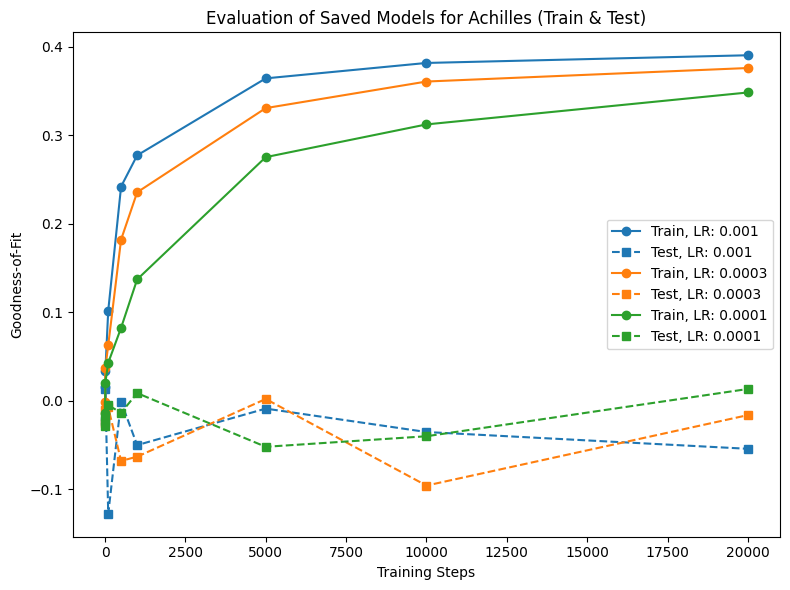

In [68]:
# --- Combined Plot for Evaluation Metrics (Train and Valid Losses) ---
fig, ax = plt.subplots(figsize=(8, 6))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Get default colors

for i, lr in enumerate(learning_rate_options):
    color = colors[i % len(colors)]
    steps_list = []
    train_losses = []
    valid_losses = []
    for steps in training_steps_options:
        steps_list.append(steps)
        train_losses.append(evaluation_results[(steps, lr)]["train_loss"])
        valid_losses.append(evaluation_results[(steps, lr)]["valid_loss"])
    # Plot train loss: solid line with circle markers.
    ax.plot(steps_list, train_losses, marker='o', linestyle='-', color=color,
            label=f"Train, LR: {lr}")
    # Plot valid loss: dashed line with square markers.
    ax.plot(steps_list, valid_losses, marker='s', linestyle='--', color=color,
            label=f"Test, LR: {lr}")

ax.set_xlabel("Training Steps")
ax.set_ylabel("Goodness-of-Fit")
ax.set_title("Evaluation of Saved Models for Achilles (Train & Test)")
ax.legend()
plt.tight_layout()
plt.savefig("./cebra_figures/hippocampus_pos_goodness_of_fit_train_test.png", bbox_inches="tight")
plt.show()


In [65]:
# Cell 4: Decoding Evaluation for All Model Configurations

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Decoding function that fits a KNN regressor once on train embeddings
# and then evaluates both on train and validation sets.
def decode_continuous_position(train_emb, valid_emb, train_pos, valid_pos, n_neighbors=30):
    knn = KNeighborsRegressor(n_neighbors=n_neighbors, metric="cosine", algorithm="brute")
    knn.fit(train_emb, train_pos)
    
    # Evaluate on the training set using the same model.
    train_pred = knn.predict(train_emb)
    train_r2 = r2_score(train_pos, train_pred)
    train_mae = mean_absolute_error(train_pos, train_pred)
    
    # Evaluate on the validation (test) set.
    test_pred = knn.predict(valid_emb)
    test_r2 = r2_score(valid_pos, test_pred)
    test_mae = mean_absolute_error(valid_pos, test_pred)
    
    return {"train_knn_r2": train_r2, "train_knn_mae": train_mae,
            "test_knn_r2": test_r2, "test_knn_mae": test_mae}

# Dictionary to store decoding performance for each model configuration.
decoding_results_all = {}

for steps in training_steps_options:
    for lr in learning_rate_options:
        model_path = f"./cebra_models/cebra_model_achilles_steps{steps}_lr{lr}.pt"
        model = cebra.CEBRA.load(model_path)
        
        # Compute embeddings using standardized data.
        train_embedding = model.transform(train_data_std)
        valid_embedding = model.transform(valid_data_std)
        
        # Evaluate decoding performance using the same KNN regressor.
        decoding = decode_continuous_position(train_embedding, valid_embedding,
                                                train_pos_unstd, valid_pos_unstd)
        decoding_results_all[(steps, lr)] = decoding
        print(f"Model steps={steps}, lr={lr} => Decoding: {decoding}")



Model steps=1, lr=0.001 => Decoding: {'train_knn_r2': 0.03459221124649048, 'train_knn_mae': 0.42490747570991516, 'test_knn_r2': -0.021799921989440918, 'test_knn_mae': 0.43944188952445984}
Model steps=1, lr=0.0003 => Decoding: {'train_knn_r2': 0.036714375019073486, 'train_knn_mae': 0.42428144812583923, 'test_knn_r2': -0.023419618606567383, 'test_knn_mae': 0.43944647908210754}
Model steps=1, lr=0.0001 => Decoding: {'train_knn_r2': 0.03512370586395264, 'train_knn_mae': 0.4248998463153839, 'test_knn_r2': -0.01600015163421631, 'test_knn_mae': 0.4384584426879883}
Model steps=10, lr=0.001 => Decoding: {'train_knn_r2': 0.04311788082122803, 'train_knn_mae': 0.4221575856208801, 'test_knn_r2': -0.022028326988220215, 'test_knn_mae': 0.439945787191391}
Model steps=10, lr=0.0003 => Decoding: {'train_knn_r2': 0.0415111780166626, 'train_knn_mae': 0.42335957288742065, 'test_knn_r2': -0.025120258331298828, 'test_knn_mae': 0.44052228331565857}
Model steps=10, lr=0.0001 => Decoding: {'train_knn_r2': 0.035

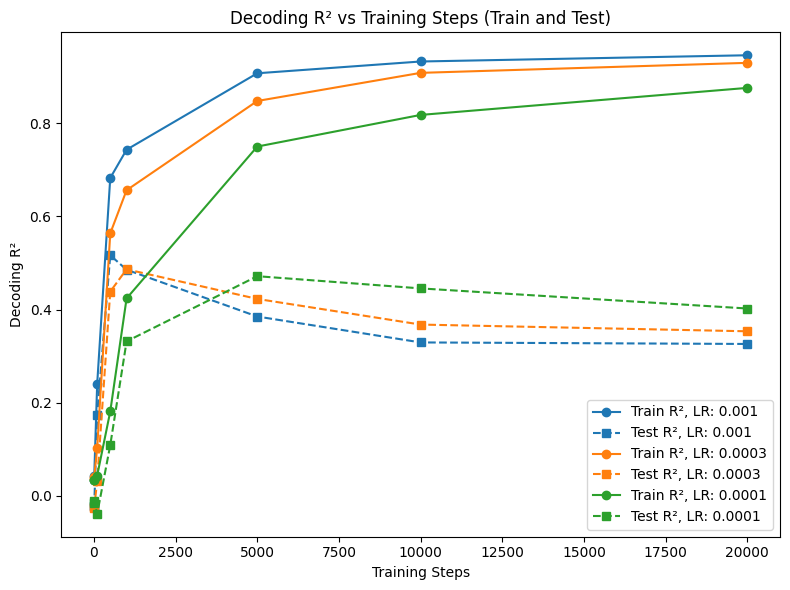

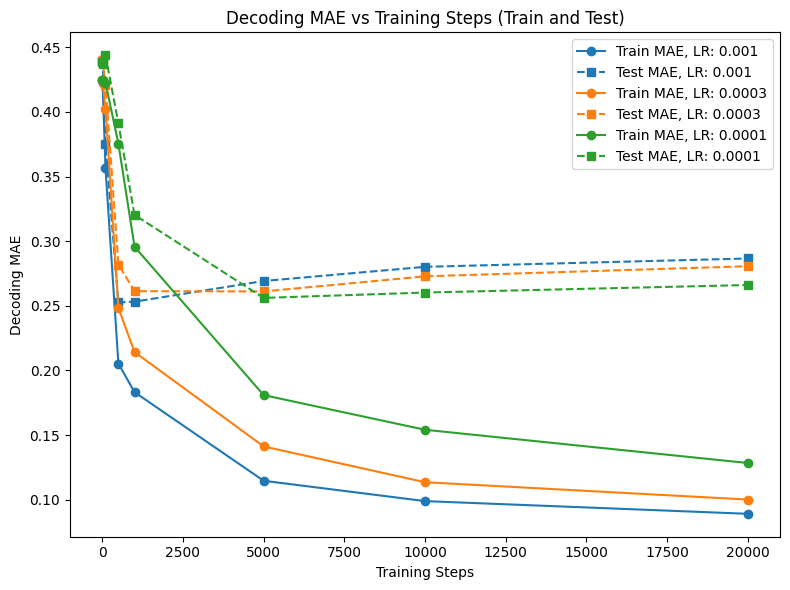

In [70]:
# --- Combined Plot for Decoding R² (Train and Test) with same colors ---
fig, ax = plt.subplots(figsize=(8,6))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Get default colors

for i, lr in enumerate(learning_rate_options):
    color = colors[i % len(colors)]  # Use the same color for this learning rate.
    steps_list = []
    train_r2_scores = []
    test_r2_scores = []
    for steps in training_steps_options:
        steps_list.append(steps)
        train_r2_scores.append(decoding_results_all[(steps, lr)]["train_knn_r2"])
        test_r2_scores.append(decoding_results_all[(steps, lr)]["test_knn_r2"])
    # Plot train scores: solid line with circle markers.
    ax.plot(steps_list, train_r2_scores, marker='o', linestyle='-', color=color, label=f"Train R², LR: {lr}")
    # Plot test scores: dashed line with square markers.
    ax.plot(steps_list, test_r2_scores, marker='s', linestyle='--', color=color, label=f"Test R², LR: {lr}")

ax.set_xlabel("Training Steps")
ax.set_ylabel("Decoding R²")
ax.set_title("Decoding R² vs Training Steps (Train and Test)")
ax.legend()
plt.tight_layout()
plt.savefig("./cebra_figures/hippocampus_pos_decoding_r2_train_test.png", bbox_inches="tight")
plt.show()

# --- Combined Plot for Decoding MAE (Train and Test) with same colors ---
fig, ax = plt.subplots(figsize=(8,6))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Re-use the default colors

for i, lr in enumerate(learning_rate_options):
    color = colors[i % len(colors)]
    steps_list = []
    train_mae_scores = []
    test_mae_scores = []
    for steps in training_steps_options:
        steps_list.append(steps)
        train_mae_scores.append(decoding_results_all[(steps, lr)]["train_knn_mae"])
        test_mae_scores.append(decoding_results_all[(steps, lr)]["test_knn_mae"])
    # Plot train scores: solid line with circle markers.
    ax.plot(steps_list, train_mae_scores, marker='o', linestyle='-', color=color, label=f"Train MAE, LR: {lr}")
    # Plot test scores: dashed line with square markers.
    ax.plot(steps_list, test_mae_scores, marker='s', linestyle='--', color=color, label=f"Test MAE, LR: {lr}")

ax.set_xlabel("Training Steps")
ax.set_ylabel("Decoding MAE")
ax.set_title("Decoding MAE vs Training Steps (Train and Test)")
ax.legend()
plt.tight_layout()
plt.savefig("./cebra_figures/hippocampus_pos_decoding_mae_train_test.png", bbox_inches="tight")
plt.show()


In [67]:
# Here we use the unstandardized continuous positions (first column) as labels for consistency.
consistency_results = {}

for steps in training_steps_options:
    for lr in learning_rate_options:
        model_path = f"./cebra_models/cebra_model_achilles_steps{steps}_lr{lr}.pt"
        model = cebra.CEBRA.load(model_path)
        
        # Compute embeddings on standardized train and test splits.
        train_embedding = model.transform(train_data_std)
        test_embedding = model.transform(valid_data_std)
        
        # Prepare embeddings and labels for consistency evaluation.
        embeddings = [train_embedding, test_embedding]
        labels = [train_pos_unstd, valid_pos_unstd]
        dataset_ids = ["train", "test"]
        
        # Compute consistency scores (returns scores for train->test and test->train).
        posdir_scores, _, _ = cebra.sklearn.metrics.consistency_score(
            embeddings=embeddings,
            labels=labels,
            dataset_ids=dataset_ids,
            between="datasets"
        )
        
        consistency_results[(steps, lr)] = {"train_to_test": posdir_scores[0],
                                            "test_to_train": posdir_scores[1]}
        print(f"Model steps={steps}, lr={lr} => Consistency: {consistency_results[(steps, lr)]}")


Model steps=1, lr=0.001 => Consistency: {'train_to_test': np.float64(0.02719799615442753), 'test_to_train': np.float64(0.04553210735321045)}
Model steps=1, lr=0.0003 => Consistency: {'train_to_test': np.float64(0.026073932647705078), 'test_to_train': np.float64(0.039954762905836105)}
Model steps=1, lr=0.0001 => Consistency: {'train_to_test': np.float64(0.02718774415552616), 'test_to_train': np.float64(0.042224686592817307)}
Model steps=10, lr=0.001 => Consistency: {'train_to_test': np.float64(0.042764026671648026), 'test_to_train': np.float64(0.053158361464738846)}
Model steps=10, lr=0.0003 => Consistency: {'train_to_test': np.float64(0.02286970615386963), 'test_to_train': np.float64(0.03979263827204704)}
Model steps=10, lr=0.0001 => Consistency: {'train_to_test': np.float64(0.0266416072845459), 'test_to_train': np.float64(0.041231412440538406)}
Model steps=100, lr=0.001 => Consistency: {'train_to_test': np.float64(0.4900082051753998), 'test_to_train': np.float64(0.6388382911682129)}
M

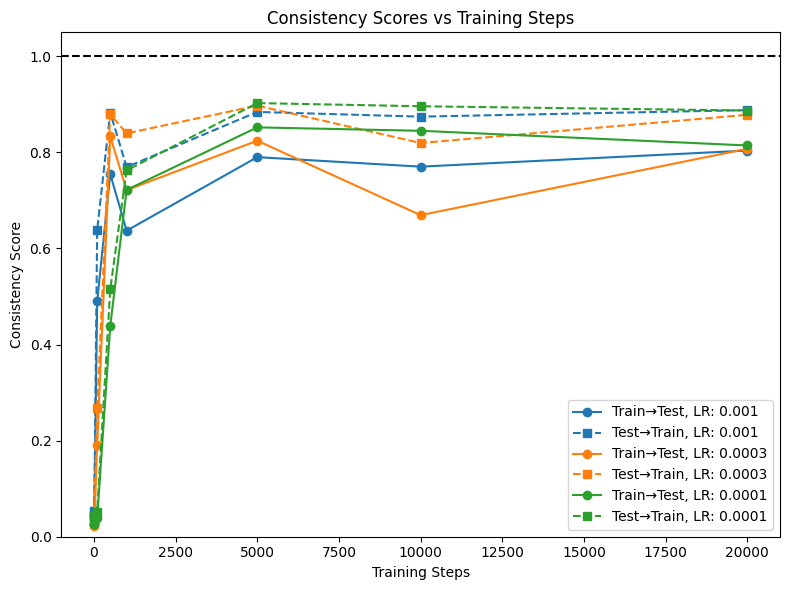

In [71]:
# --- Combined Plot for Consistency Scores (Train→Test and Test→Train) with same colors ---
fig, ax = plt.subplots(figsize=(8,6))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Get default color cycle

for i, lr in enumerate(learning_rate_options):
    color = colors[i % len(colors)]
    steps_list = []
    cons_train_to_test = []
    cons_test_to_train = []
    for steps in training_steps_options:
        steps_list.append(steps)
        cons_train_to_test.append(consistency_results[(steps, lr)]["train_to_test"])
        cons_test_to_train.append(consistency_results[(steps, lr)]["test_to_train"])
    # Plot train→test consistency: solid line with circle markers.
    ax.plot(steps_list, cons_train_to_test, marker='o', linestyle='-', color=color,
            label=f"Train→Test, LR: {lr}")
    # Plot test→train consistency: dashed line with square markers.
    ax.plot(steps_list, cons_test_to_train, marker='s', linestyle='--', color=color,
            label=f"Test→Train, LR: {lr}")

ax.set_xlabel("Training Steps")
ax.set_ylabel("Consistency Score")
ax.set_title("Consistency Scores vs Training Steps")
ax.set_ylim(0.0, 1.05)
ax.axhline(1.0, ls='--', color='k')
ax.legend()
plt.tight_layout()
plt.savefig("./cebra_figures/hippocampus_pos_consistency_train_test.png", bbox_inches="tight")
plt.show()
